## 1. Import/Install Dependencies

In [7]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env
from gymnasium.utils import env_checker
from gymnasium.spaces import Box, Discrete
from mss import mss
import cv2
import pydirectinput
import torch
from torch import nn

# Check version of pytorch
torch.__version__

'2.4.1+cu124'

## 2. Construct Environment

In [54]:
class PacMan(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,50,80), dtype=np.uint8)
        self.action_space = Discrete(5)
        self.game_location = {'top':50, 'left':-2280, 'width':2000, 'height':1300}
        self.lives_location = {'top':1070, 'left':-902, 'width':600, 'height':200}
        self.cap = mss()
        
    # Action method that is called to do something in the game
    def step(self, action):
        action_map = {
            0: 'left',   # Move Left
            1: 'right',  # Move Right
            2: 'up',     # Move Up
            3: 'down',   # Move Down
            4: 'no_op'   # No operation (do nothing)
        }
        total_reward = 0
        if action != 4:
            pydirectinput.press(action_map[action])
        
        # Get the next observation
        new_observation = self.get_observation()
        # Determine if the game is finished   
        done = self.get_done()
        
        reward = 1
        if done:
            reward -= 10
        total_reward += reward
        
            
        # Info dictionary
        info = {} # needed for stablebaselines what it expects
        
        return new_observation, total_reward, done, False, info
    
    def get_observation(self):
        # Get screen capture of game
        raw_screen_cap = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # Convert to Grayscale
        gray_cap = cv2.cvtColor(raw_screen_cap, cv2.COLOR_BGR2GRAY)
        # Resize capture
        resized = cv2.resize(gray_cap, (80,50))
        # Add channels first
        channel = np.reshape(resized, (1,50,80))
        return channel, raw_screen_cap, gray_cap
    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Method to Restart the game
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        pydirectinput.click(x=-890, y=374) # select game window
        pydirectinput.press('f1') # Start state 1 save
        return self.get_observation(), {}
    
    def close(self):
        cv2.destroyAllWindows()
        
    def get_done(self):
        # Capture the area where the lives are displayed
        lives_cap = np.array(self.cap.grab(self.lives_location))[:,:,:3]
        # Convert to grayscale
        lives_gray = cv2.cvtColor(lives_cap, cv2.COLOR_BGR2GRAY)
        # Load pacman life icon template for comparison
        pacman_life_template = cv2.imread('pacman_life_icon.png', 0)
        # Perform template matching using computer vision
        result = cv2.matchTemplate(lives_gray, pacman_life_template, cv2.TM_CCORR_NORMED)
        threshold = 0.8
        locations = np.where(result >= threshold)
        lives_value = len(list(zip(*locations[::-1])))
        
        # Determine number of lives
        if lives_value == 684:
            num_lives = 2
        elif lives_value == 344:
            num_lives = 1
        else:
            num_lives = 0
            
        return num_lives == 0, lives_cap, lives_value

#### Demonstration

In [55]:
# declare environment
env = PacMan()

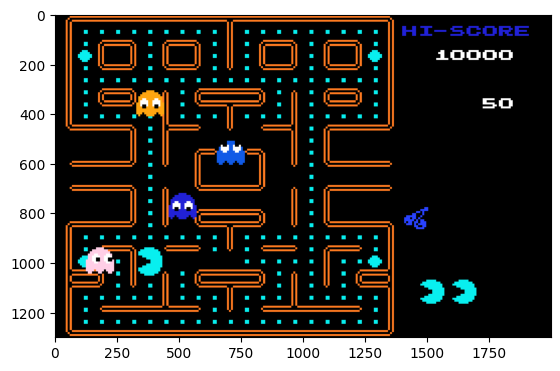

In [37]:
# check observation space
channel, raw_screen_cap, gray_cap = env.get_observation()
plt.imshow(raw_screen_cap)

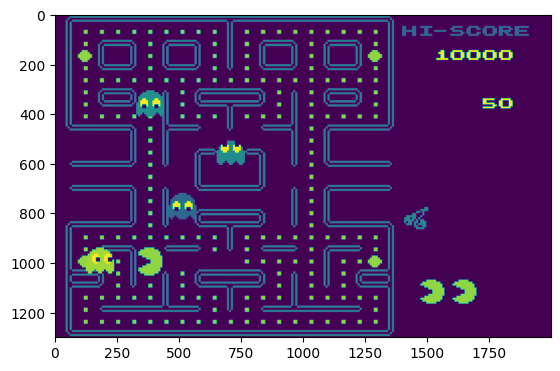

In [38]:
plt.imshow(gray_cap)

Game done?: False
Number of Lives left: 684


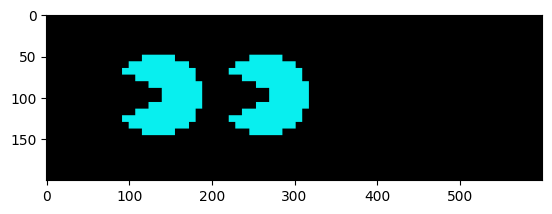

In [43]:
# check get_done method
done, lives_cap, lives_value= env.get_done()
print(f"Game done?: {done}") # is the game over?
print(f"Number of Lives left: {lives_value}") # how the pictures where interpreted to numbers
plt.imshow(lives_cap) # what the computer sees

In [ ]:
# how I determined the location of the observation space and the lives
import pydirectinput
import time

print("Move your mouse to the desired position and wait 5 seconds...")
time.sleep(5)
x, y = pydirectinput.position()
print(f"Mouse position: x={x}, y={y}")

In [44]:
# demonstration of rendering a screen to watch the model
env.render() # explain how this isn't necessary because I can already see it

In [45]:
# demonstration of closing the window
env.close()

In [47]:
# reset demo
env.reset()

((array([[[  0,   0, 111, ...,   0,   0,   0],
          [  0,   0, 111, ...,   0,   0,   0],
          [  0,   0, 111, ...,   0,   0,   0],
          ...,
          [  0,   0, 111, ...,   0,   0,   0],
          [  0,   0, 111, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8),
  array([[[242, 242, 242],
          [242, 242, 242],
          [242, 242, 242],
          ...,
          [251, 251, 251],
          [251, 251, 251],
          [251, 251, 251]],
  
         [[242, 242, 242],
          [242, 242, 242],
          [242, 242, 242],
          ...,
          [251, 251, 251],
          [251, 251, 251],
          [251, 251, 251]],
  
         [[242, 242, 242],
          [242, 242, 242],
          [242, 242, 242],
          ...,
          [251, 251, 251],
          [251, 251, 251],
          [251, 251, 251]],
  
         ...,
  
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
    

#### Putting it together

In [56]:
# demo of the computer controlling the game
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = env.action_space.sample() # get an action
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
        

Total Reward for episode 0 is -9
Total Reward for episode 1 is -9
Total Reward for episode 2 is -9
Total Reward for episode 3 is -9
Total Reward for episode 4 is -9
Total Reward for episode 5 is -9
Total Reward for episode 6 is -9
Total Reward for episode 7 is -9
Total Reward for episode 8 is -9
Total Reward for episode 9 is -9
